In [569]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.initializers import HeNormal
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import tensorflow as tf

seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)


In [570]:

!mkdir -p ~/.kaggle
!cp kaggle-2.json ~/.kaggle/

cp: cannot stat 'kaggle-2.json': No such file or directory


In [571]:
! kaggle datasets download -d "minatverma/nse-stocks-data"


Dataset URL: https://www.kaggle.com/datasets/minatverma/nse-stocks-data
License(s): CC0-1.0
nse-stocks-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [572]:
import zipfile
zip_ref = zipfile.ZipFile('/content/nse-stocks-data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [573]:
data = pd.read_csv('/content/FINAL_FROM_DF.csv')

In [574]:
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

In [575]:
idfc = data[(data['SYMBOL'] == 'IDFCBANK') & (data['SERIES'] == 'EQ')]

In [576]:
idfc = idfc.sort_values(by='TIMESTAMP', ascending=True)

In [577]:
idfc = idfc.drop(['SYMBOL', 'SERIES', 'ISIN'], axis=1)
idfc.set_index('TIMESTAMP', inplace=True)

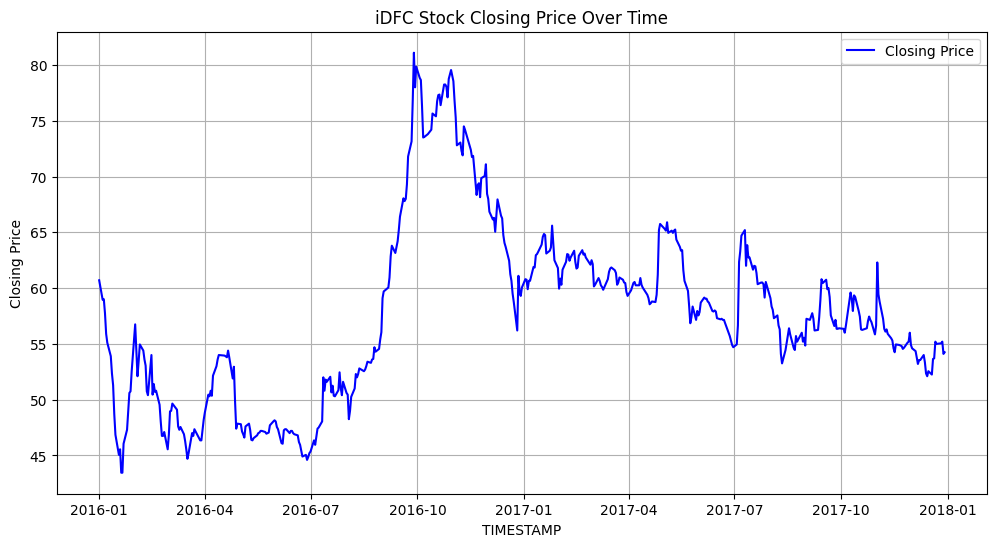

In [578]:
plt.figure(figsize=(12, 6))
plt.plot(idfc.index, idfc['CLOSE'], label='Closing Price', color='blue')
plt.title("iDFC Stock Closing Price Over Time")
plt.xlabel("TIMESTAMP")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.show()

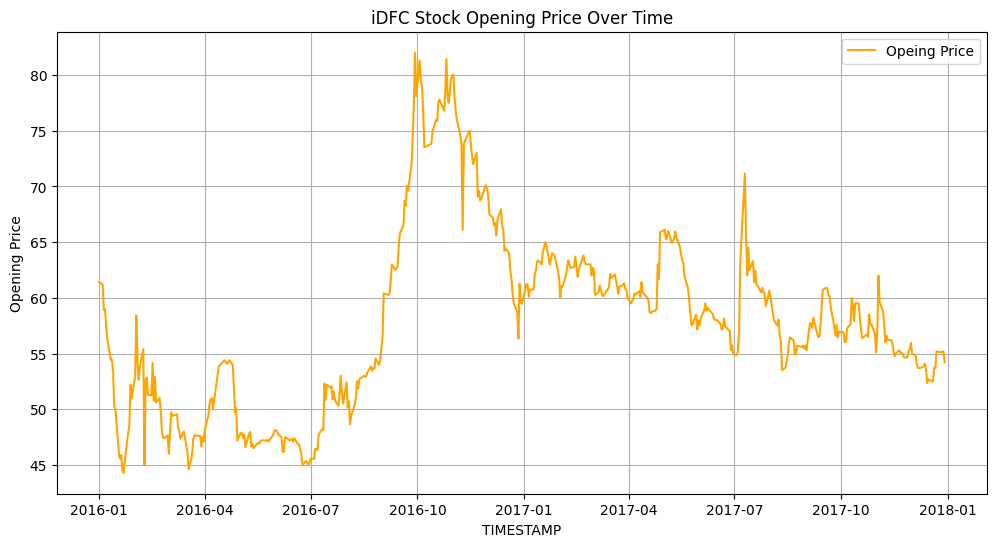

In [579]:
plt.figure(figsize=(12, 6))
plt.plot(idfc.index, idfc['OPEN'], label='Opeing Price', color='orange')
plt.title("iDFC Stock Opening Price Over Time")
plt.xlabel("TIMESTAMP")
plt.ylabel("Opening Price")
plt.legend()
plt.grid(True)
plt.show()

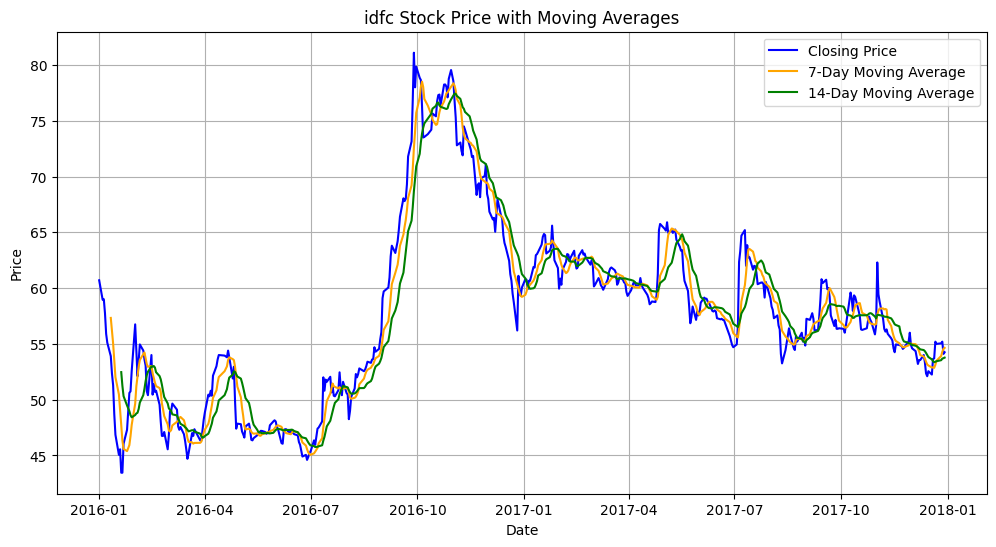

In [580]:
idfc['MA_7'] = idfc['CLOSE'].rolling(window=7).mean()
idfc['MA_14'] = idfc['CLOSE'].rolling(window=14).mean()

plt.figure(figsize=(12, 6))
plt.plot(idfc.index, idfc['CLOSE'], label='Closing Price', color='blue')
plt.plot(idfc.index, idfc['MA_7'], label='7-Day Moving Average', color='orange')
plt.plot(idfc.index, idfc['MA_14'], label='14-Day Moving Average', color='green')
plt.title("idfc Stock Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [581]:
idfc.isnull().sum()

,0
OPEN,0
HIGH,0
LOW,0
CLOSE,0
LAST,0
PREVCLOSE,0
TOTTRDQTY,0
TOTTRDVAL,0
TOTALTRADES,0
MA_7,6


In [582]:
idfc.corr()

,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TOTALTRADES,MA_7,MA_14
OPEN,1.000000,0.991984,0.991920,0.987385,0.986994,0.995470,0.286868,0.340175,0.563118,0.978502,0.948130
HIGH,0.991984,1.000000,0.988279,0.995503,0.995311,0.991451,0.312977,0.364320,0.597273,0.973582,0.940253
LOW,0.991920,0.988279,1.000000,0.993408,0.992910,0.991492,0.279426,0.332218,0.551565,0.978625,0.950395
CLOSE,0.987385,0.995503,0.993408,1.000000,0.999786,0.988958,0.300292,0.352038,0.576880,0.973866,0.942425
LAST,0.986994,0.995311,0.992910,0.999786,1.000000,0.988611,0.302467,0.354377,0.577993,0.973374,0.941833
PREVCLOSE,0.995470,0.991451,0.991492,0.988958,0.988611,1.000000,0.289757,0.343240,0.561899,0.984928,0.953782
TOTTRDQTY,0.286868,0.312977,0.279426,0.300292,0.302467,0.289757,1.000000,0.995175,0.686219,0.265691,0.262649
TOTTRDVAL,0.340175,0.364320,0.332218,0.352038,0.354377,0.343240,0.995175,1.000000,0.691903,0.317468,0.311493
TOTALTRADES,0.563118,0.597273,0.551565,0.576880,0.577993,0.561899,0.686219,0.691903,1.000000,0.546542,0.538553
MA_7,0.978502,0.973582,0.978625,0.973866,0.973374,0.984928,0.265691,0.317468,0.546542,1.000000,0.981993


In [583]:
idf=idfc.fillna(method='ffill')
idfc = idfc.fillna(method='bfill')

<ipython-input-583-5148599eb859>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  idf=idfc.fillna(method='ffill')
<ipython-input-583-5148599eb859>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  idfc = idfc.fillna(method='bfill')


In [584]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Example: Calculate VIF
X = idfc[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'LAST', 'PREVCLOSE', 'MA_7', 'MA_14']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


     Feature            VIF
0       OPEN   12632.749427
1       HIGH   17434.438089
2        LOW   12396.750088
3      CLOSE  155994.180206
4       LAST  127972.492528
5  PREVCLOSE   10392.665132
6       MA_7    5372.479228
7      MA_14    1614.326900


In [585]:
idfc = idfc[['CLOSE', 'OPEN','MA_14']]


In [588]:
train_size = int(len(idfc) * 0.8)
train_data = idfc[:train_size]
test_data = idfc[train_size:]

In [589]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)


In [590]:
look_back = 60
X_train, y_train = [], []
for i in range(look_back, len(scaled_train)):
    X_train.append(scaled_train[i - look_back:i])
    y_train.append(scaled_train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [591]:
X_test, y_test = [], []
for i in range(look_back, len(scaled_test)):
    X_test.append(scaled_test[i - look_back:i])
    y_test.append(scaled_test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [592]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [593]:
print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(336, 60, 3) (39, 60, 3)
(336,) (39,)


In [594]:
model = Sequential()

model.add(LSTM(units=100, return_sequences=True,
               input_shape=(X_train.shape[1], X_train.shape[2]),
               kernel_initializer=HeNormal()))

model.add(LSTM(units=100, return_sequences=False,  # return_sequences=False as this is the last LSTM layer
               kernel_initializer=HeNormal()))

model.add(Dropout(0.4))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [595]:
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                       │ (None, 60, 100)             │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,101 (476.96 KB)

 Trainable params: 122,101 (476.96 KB)

 Non-trainable params: 0 (0.00 B)

In [596]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=4,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.1178 - val_loss: 0.0035
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0290 - val_loss: 0.0031
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0159 - val_loss: 0.0058
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0090 - val_loss: 0.0010
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0079 - val_loss: 9.7058e-04
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0069 - val_loss: 0.0084
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0084 - val_loss: 0.0031
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0047 - val_loss: 7.1404e-04
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 12/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - l

In [597]:
predicted_price = model.predict(X_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step


In [598]:
predicted_price = scaler.inverse_transform(np.concatenate((predicted_price, np.zeros((predicted_price.shape[0], scaled_train.shape[1] - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_train.shape[1] - 1))), axis=1))[:, 0]


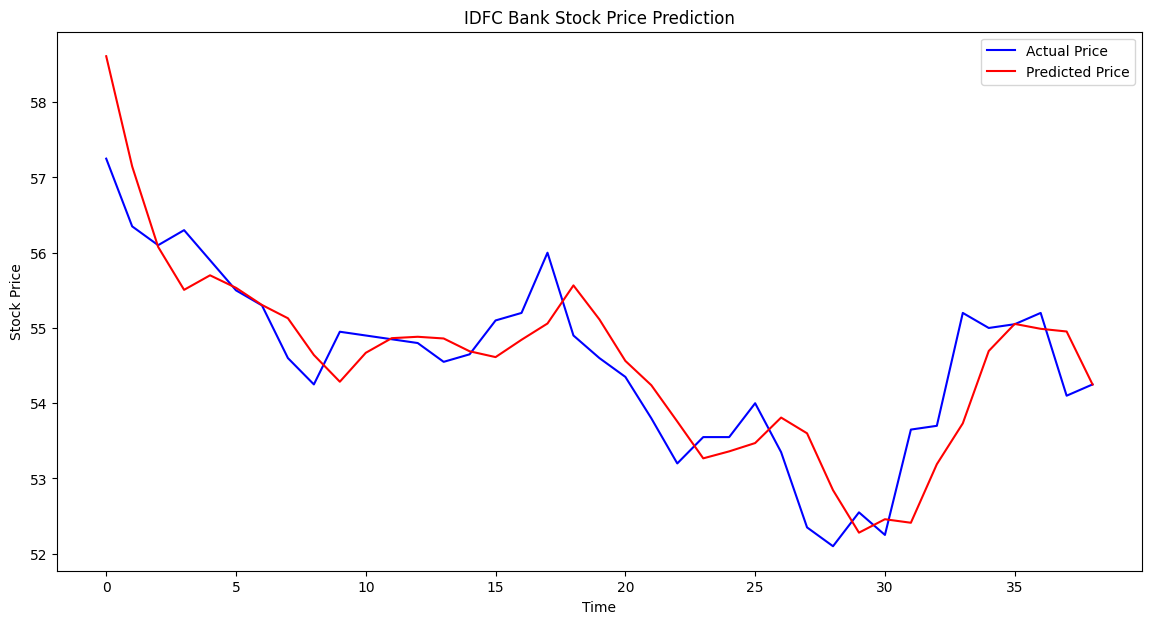

In [599]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color='blue', label='Actual Price')
plt.plot(predicted_price, color='red', label='Predicted Price')
plt.title('IDFC Bank Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [600]:
rmse = math.sqrt(mean_squared_error(y_test_actual, predicted_price))
mae = mean_absolute_error(y_test_actual, predicted_price)
train_predicted_price = model.predict(X_train)
train_predicted_price = scaler.inverse_transform(np.concatenate((train_predicted_price, np.zeros((train_predicted_price.shape[0], scaled_train.shape[1] - 1))), axis=1))[:, 0]
y_train_actual = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], scaled_train.shape[1] - 1))), axis=1))[:, 0]
train_r2 = r2_score(y_train_actual, train_predicted_price)
test_r2 = r2_score(y_test_actual, predicted_price)


print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f"R² score for Training Data: {train_r2}")
print(f"R² score for Test Data: {test_r2}")



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
RMSE: 0.6065773620287108
MAE: 0.4660357162929495
R² score for Training Data: 0.973961740647482
R² score for Test Data: 0.7250734797428702


In [603]:
future_days = 30
current_input = scaled_test[-look_back:]
current_input = np.reshape(current_input, (1, look_back, scaled_test.shape[1]))

predicted_future_prices = []

for _ in range(future_days):
    predicted_price_next = model.predict(current_input)
    predicted_price_next_reshaped = np.reshape(predicted_price_next, (1, 1, 1))
    zeros = np.zeros((1, 1, scaled_test.shape[1] - 1))
    predicted_price_next_with_zeros = np.concatenate((predicted_price_next_reshaped, zeros), axis=2)
    current_input = np.append(current_input[:, 1:, :], predicted_price_next_with_zeros, axis=1)
    predicted_future_prices.append(predicted_price_next[0, 0])


last_date = test_data.index[-1]
future_dates = pd.date_range(last_date, periods=future_days + 1, freq='B')[1:]
predicted_future_prices_actual = scaler.inverse_transform(
    np.concatenate((np.array(predicted_future_prices).reshape(-1, 1), np.zeros((len(predicted_future_prices), scaled_test.shape[1] - 1))), axis=1))[:, 0]

past_60_days_prices_actual = scaler.inverse_transform(scaled_test[-look_back:])[:, 0]
past_dates = test_data.index[-look_back:]

all_dates = np.concatenate([past_dates, future_dates])
all_prices = np.concatenate([past_60_days_prices_actual, predicted_future_prices_actual])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

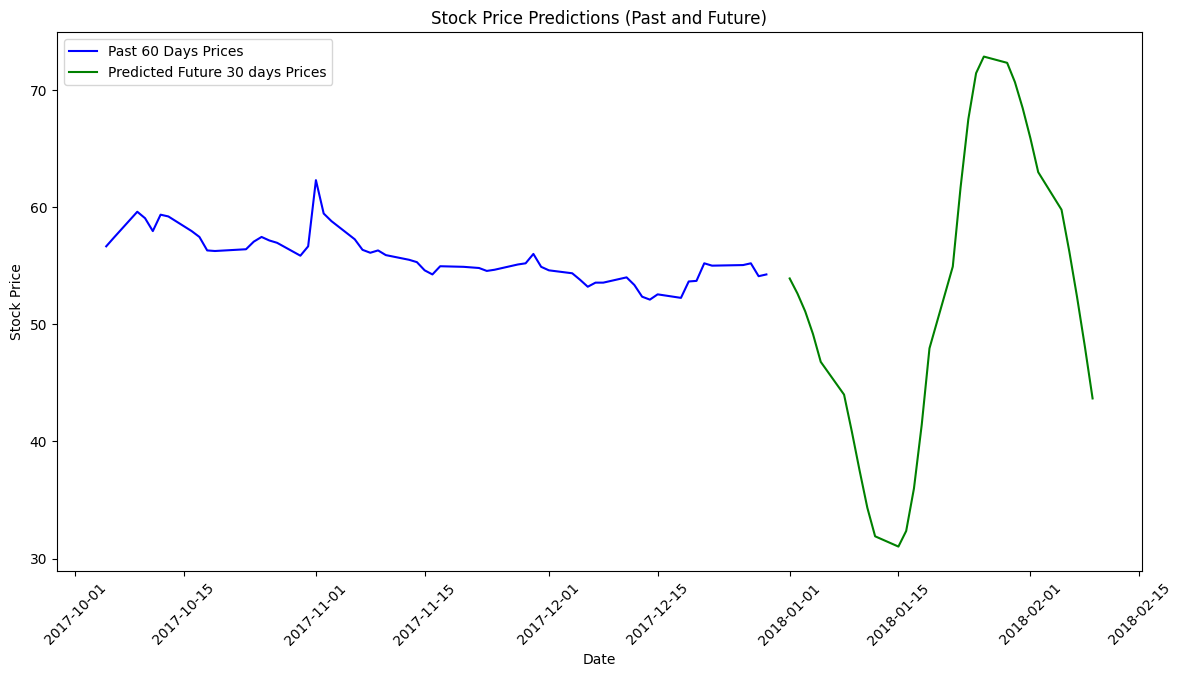

In [604]:
plt.figure(figsize=(14, 7))
plt.plot(past_dates, past_60_days_prices_actual, color='blue', label='Past 60 Days Prices')
plt.plot(future_dates, predicted_future_prices_actual, color='green', label='Predicted Future 30 days Prices')
plt.title('Stock Price Predictions (Past and Future)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()
